In [1]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from PIL import Image, ImageDraw

from process import map_vgrade, id_to_index, id_to_coordinate, frame_to_ids, frame_to_triplets, triplets_to_matrix, frame_to_sparse_matrix, is_frame_valid, filter_frame, filter_climbs, sort_frame, filtered_df_to_text_file, id_to_index2, index2_to_id, coordinates_distribution_to_index2
from visualize import analyze_starting_hold_heights, plot_vgrade_counts, plot_hold_counts, print_unique_climbs_count, count_unique_words, draw_colored_circles_on_image, frame_to_imagecoords, frame_to_image
from markov import Markov, predict_valid_sequence
import embeddings as emb
from embeddings import hold_directions2, hold_directions, hold_magnitudes
import torch
from torch.utils.data import Dataset

ModuleNotFoundError: No module named 'process'

### Creating SQL Database Connection and Converting tables to dfs ###

In [ ]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [ ]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

# print("Number of climbs:", filtered_df.shape[0])

### Some Graphs

In [ ]:
# plot_vgrade_counts(filtered_df)
# plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [ ]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


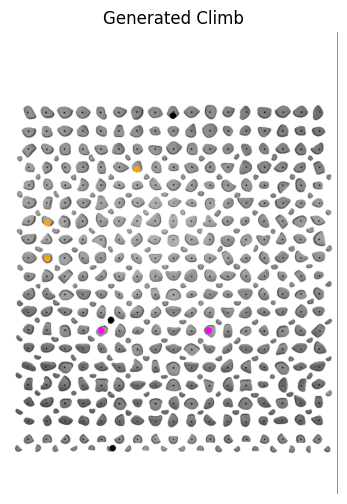

Climb Name: still dreaming


In [ ]:
# frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
# frame_to_image(frame)
def create_random_climb_image(filtered_df):
    if not filtered_df.empty:
        # Select a random row
        random_row = filtered_df.sample(n=1).iloc[0]

        # Extract the frame and climb name from the random row
        random_frame = random_row['frames']
        climb_name = random_row['name']  # Adjust this according to the actual column name in your DataFrame

        # Create the image for the random frame
        frame_to_image(random_frame)

        # Print the climb name
        print("Climb Name:", climb_name)
    else:
        print("The DataFrame is empty.")

# Example usage:
create_random_climb_image(filtered_df) 

### Markov Chain Model

In [ ]:
from collections import defaultdict
import string
import random
from collections import defaultdict, Counter
class Markov():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text = self.remove_punctuations(self.get_text())
        self.model = self.model()

    def get_text(self):
        text = []
        for line in open(self.file_path):
            text.append(line)
        return ' '.join(text)
    
    def remove_punctuations(self, text):
        return text.translate(str.maketrans('','', string.punctuation))
    
    def model(self):
        # split the input text into individual words seperated by spaces
        words = self.text.split(' ')
        markov_dict = defaultdict(list)
        # create list of all word pairs
        for current_word, next_word in zip(words[0:-1], words[1:]):
            markov_dict[current_word].append(next_word)
        markov_dict = dict(markov_dict)
        print('Successfully Trained')
        return markov_dict
    
def predict_words(chain, first_word, number_of_words):
    if first_word in list(chain.keys()):
        word1 = str(first_word)
        predictions = word1.capitalize()
        # Generate the second word from the value list. Set the new word as the first word. Repeat.
        for i in range(number_of_words):
            if word1 not in chain:
                break
            next_words = chain[word1]
            word_counts = Counter(next_words)
            total_count = sum(word_counts.values())
            probabilities = {word: count / total_count for word, count in word_counts.items()}

            # Print the probabilities
            print(f"Current word: {word1}")
            print("Next word probabilities:")
            for word, prob in probabilities.items():
                print(f"  {word}: {prob:.2f}")

            # Choose the next word based on the probabilities
            word2 = random.choices(list(probabilities.keys()), weights=probabilities.values())[0]
            word1 = word2
            predictions += ' ' + word2
        return predictions
    else:
        return "Word not in corpus"
    
def is_valid_sequence(sequence):
    # Count the number of start holds (r12) and finish holds (r14)
    start_hold_count = sequence.count('r12')
    finish_hold_count = sequence.count('r14')

    # Check if the counts are within the specified range
    return 1 <= start_hold_count <= 2 and 1 <= finish_hold_count <= 2

def predict_valid_sequence(chain, start_hold, number_of_words):
    while True:
        # Generate a sequence of words using the Markov chain model
        sequence = predict_words(chain, start_hold, number_of_words)
        
        # Convert the sequence to a string
        sequence_str = ' '.join(sequence.split())
        # Check if the sequence is valid
        if is_valid_sequence(sequence_str):
            return sequence_str

Successfully Trained
Current word: 1081r15
Next word probabilities:
  1080r15: 0.04
  1133r12: 0.01
  1472r15: 0.01
  1144r12: 0.00
  1150r15: 0.00
  1131r15: 0.01
  1096r15: 0.03
  1471r15: 0.02
  1469r15: 0.03
  1476r15: 0.02
  1092r15: 0.00
  1470r15: 0.03
  1490r15: 0.00
  1149r12: 0.06
  1098r15: 0.00
  1076r15: 0.02
  1130r15: 0.01
  1110r15: 0.01
  1079r15: 0.03
  1503r15: 0.00
  1468r15: 0.03
  1078r15: 0.03
  1146r12: 0.01
  1103r15: 0.01
  1138r12: 0.00
  1097r15: 0.02
  1128r12: 0.01
  1148r12: 0.01
  1131r12: 0.01
  1169r12: 0.00
  1099r12: 0.00
  1478r15: 0.01
  1111r15: 0.00
  1475r15: 0.00
  1136r12: 0.01
  1147r12: 0.02
  1489r15: 0.01
  1113r15: 0.02
  1486r15: 0.01
  1133r15: 0.01
  1114r12: 0.01
  1134r12: 0.01
  1129r12: 0.01
  1488r15: 0.01
  1112r12: 0.00
  1166r12: 0.02
  1127r12: 0.01
  1164r12: 0.00
  1153r12: 0.00
  1101r15: 0.00
  1117r12: 0.00
  1116r15: 0.00
  1077r15: 0.02
  1480r15: 0.01
  1106r15: 0.00
  1151r12: 0.00
  1145r12: 0.01
  1094r15: 0.00
  10

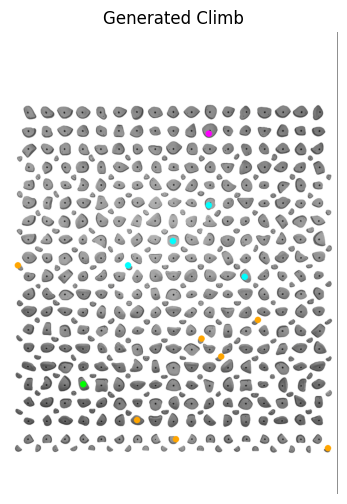

In [ ]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1081r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [ ]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

In [ ]:
print(len(filtered_df))

98951


### Prepare Data into npz file ###

In [ ]:
def get_hold_vector(row, col):
    if not isinstance(row, int):
        raise TypeError(f"Row index must be an integer, got {type(row)} row: {row}")
    if not isinstance(col, int):
        raise TypeError(f"Column index must be an integer, got {type(col)} col: {col}")
    
    if row > 34 or col > 34:
        if row > col:
            raise ValueError(f"Row index {row} exceeds maximum allowed value of 34.")
        else:
            raise ValueError(f"Column index {col} exceeds maximum allowed value of 34.")
    
    if max(hold_directions[34 - row][col]) > 1:
        index = int(hold_directions[34 - row][col][0]) - 1
        hold_direction = hold_directions2[index].tolist()
    else:
        hold_direction = hold_directions[34 - row][col].tolist()
    
    hold_magnitude = hold_magnitudes[34 - row][col][0]
    
    return hold_direction, hold_magnitude

# hold_direction, hold_magnitude = get_hold_vector(row, col)

def unit_vector_to_sin(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    sin_value = np.sin(angle_radians)
    return sin_value

def unit_vector_to_cos(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    cos_value = np.cos(angle_radians)
    return cos_value

def modified_hold_quality(climb_angle, hold_quality):
    if isinstance(climb_angle, torch.Tensor):
        climb_angle_cpu = climb_angle.cpu().numpy()
    else:
        climb_angle_cpu = np.array(climb_angle)
    climb_angle_radians = np.deg2rad(climb_angle_cpu)
    modified_quality = np.cos(climb_angle_radians * hold_quality)
    return modified_quality

def interhold_angle(a, b):
    x1, y1 = a
    x2, y2 = b
    angle_radians = np.arctan2(y2 - y1, x2 - x1)
    return angle_radians

def average_unit_vectors(vectors):
    if len(vectors) == 1:
        return vectors[0]
    elif len(vectors) == 2:
        avg_x = (vectors[0][0] + vectors[1][0]) / 2
        avg_y = (vectors[0][1] + vectors[1][1]) / 2
        norm = np.sqrt(avg_x**2 + avg_y**2)
        return [avg_x / norm, avg_y / norm]
    else:
        raise ValueError("The input should be a list containing one or two unit vectors.")

def id_to_class_id(id):
    if id <=1089: # 0-16
        class_id = id - 1073 
    elif id <=1395: # 17-322
        class_id = id - 1090 + 17
    elif id <= 1464: # 323-340
        class_id = id - 1447 + 323
    elif id <= 1599: # 341-475
        class_id = id - 1465 + 341
    return class_id

def class_id_to_id(class_id):
    if class_id <= 16:  # 0-16
        id = class_id + 1073
    elif class_id <= 322:  # 17-322
        id = class_id + 1090 - 17
    elif class_id <= 340:  # 323-340
        id = class_id + 1447 - 323
    elif class_id <= 475:  # 341-475
        id = class_id + 1465 - 341 
    return id

def ids_to_hold_val_class_id(hold_class_id, val_class_id):
    hold_val_class_id = (hold_class_id) * 4 + val_class_id
    return hold_val_class_id

def hold_val_class_id_to_ids(hold_val_class_id):
    val_class_id = hold_val_class_id % 4
    hold_class_id = int((hold_val_class_id - val_class_id) /4)
    return hold_class_id, val_class_id

def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_index2 = id_to_index2(hold_ids[i])
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_index2, hold_val_class_id, hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=40000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = np.copy(matrix)
    standardized_matrix[:, [0, 1, 5, 6]] = (matrix[:, [0, 1, 5, 6]] - global_means[[0, 1, 5, 6]]) / global_stds[[0, 1, 5, 6]]
    return standardized_matrix


def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def hold_to_tuple(index2, val,):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = index2_to_id(int(index2))
    hold_class_id = id_to_class_id(hold_id)
    x, y = id_to_coordinate(hold_id)

    val_class_id = val-2
    hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    
    feature_tuple = (y, x, val_class_id, index2, hold_val_class_id, hold_angle, hold_quality)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple

[ 1.73130243e+01  1.70312480e+01  1.63025224e+00  2.41099456e+02
  9.01063403e+02 -3.21942039e-03  5.93284378e-01]


### RNN Model ###

Train and Val Datasets Created
Sequence Train and Val Datasets Created
Train Dataset Size: 306274
Validation Dataset Size: 87200
Test Dataset Size: 4000
Train and Val Loaders Created
Epoch [1/10], Train Loss: 10.0421, Train Row Accuracy: 0.3170, Train Col Accuracy: 0.1192, Train Hold Class Accuracy: 0.0557, Train Val Accuracy: 0.6471, Val Loss: 9.6385, Val Row Accuracy: 0.3434, Val Col Accuracy: 0.1293, Val Hold Class Accuracy: 0.0678, Val Val Accuracy: 0.6708
Epoch [2/10], Train Loss: 9.5074, Train Row Accuracy: 0.3395, Train Col Accuracy: 0.1400, Train Hold Class Accuracy: 0.0748, Train Val Accuracy: 0.6694, Val Loss: 9.3742, Val Row Accuracy: 0.3463, Val Col Accuracy: 0.1472, Val Hold Class Accuracy: 0.0815, Val Val Accuracy: 0.6778
Epoch [3/10], Train Loss: 9.3459, Train Row Accuracy: 0.3470, Train Col Accuracy: 0.1475, Train Hold Class Accuracy: 0.0826, Train Val Accuracy: 0.6762, Val Loss: 9.3565, Val Row Accuracy: 0.3526, Val Col Accuracy: 0.1429, Val Hold Class Accuracy: 0.0818

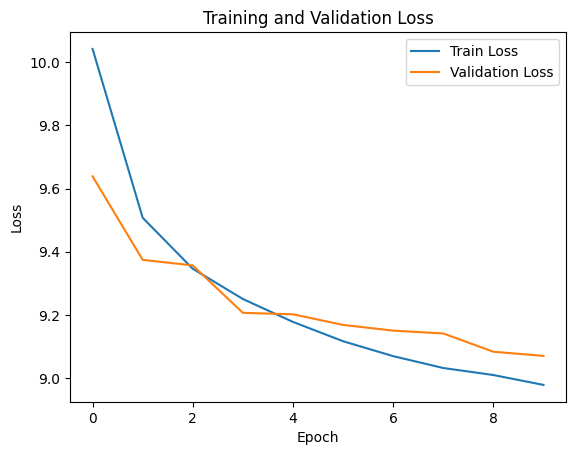

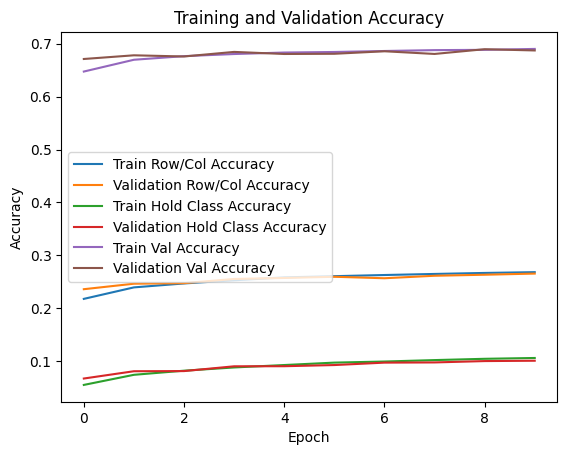

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.parametrizations as weight_norm
import torch.nn.init as init

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        climb_name = list(self.data.keys())[idx]
        climb_matrix = self.data[climb_name]
        row_labels = climb_matrix[:, 0].astype(int)
        col_labels = climb_matrix[:, 1].astype(int)
        hold_class_labels = climb_matrix[:, 3].astype(int)
        val_labels = climb_matrix[:, 2].astype(int)
        angle_labels = climb_matrix[:, 5].astype(float) 
        return climb_matrix, row_labels, col_labels, hold_class_labels, val_labels, angle_labels

class SequenceDataset(Dataset):
    def __init__(self, dataset):
        self.sequences, self.row_labels, self.col_labels, self.hold_class_labels, self.val_labels, self.angle_labels = self.extract_sequences(dataset)

    def extract_sequences(self, dataset):
        sequences = []
        row_labels = []
        col_labels = []
        hold_class_labels = []
        val_labels = []
        angle_labels = []

        for i in range(len(dataset)):
            climb_matrix, row_ids, col_ids, hold_class_ids, vals, angles = dataset[i]
            for j in range(1, len(climb_matrix)):
                sequence = climb_matrix[:j]
                row_label = row_ids[j]
                col_label = col_ids[j]
                hold_class_label = hold_class_ids[j]
                val_label = vals[j]
                angle_label = angles[j]
                sequences.append(sequence)
                row_labels.append(row_label)
                col_labels.append(col_label)
                hold_class_labels.append(hold_class_label)
                val_labels.append(val_label)
                angle_labels.append(angle_label)
        return sequences, row_labels, col_labels, hold_class_labels, val_labels, angle_labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        row_label = self.row_labels[idx]
        col_label = self.col_labels[idx]
        hold_class_label = self.hold_class_labels[idx]
        val_label = self.val_labels[idx]
        angle_label = self.angle_labels[idx]
        return sequence, row_label, col_label, hold_class_label, val_label, angle_label

class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize LSTM weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Task-specific layers
        self.fc_row = nn.Linear(hidden_size, 35)  # Predict 35 values for row
        self.fc_col = nn.Linear(hidden_size, 35)  # Predict 35 values for col
        self.fc_hold_class = nn.Linear(hidden_size, 476)  # Predict 476 values for hold class
        self.fc_val = nn.Linear(hidden_size, 4)  # Predict 4 values for val
        self.fc_angle = nn.Linear(hidden_size, 1)  # Predict 1 value for angle (regression)

        # Initialize FC layer weights
        init.xavier_uniform_(self.fc_row.weight)
        init.constant_(self.fc_row.bias, 0)
        
        init.xavier_uniform_(self.fc_col.weight)
        init.constant_(self.fc_col.bias, 0)

        init.xavier_uniform_(self.fc_hold_class.weight)
        init.constant_(self.fc_hold_class.bias, 0)

        init.xavier_uniform_(self.fc_val.weight)
        init.constant_(self.fc_val.bias, 0)

        init.xavier_uniform_(self.fc_angle.weight)
        init.constant_(self.fc_angle.bias, 0)
        
    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        row_pred = self.fc_row(out)
        col_pred = self.fc_col(out)
        hold_class_pred = self.fc_hold_class(out)
        val_pred = self.fc_val(out)
        angle_pred = self.fc_angle(out)  # Regression output for angle
        
        return row_pred, col_pred, hold_class_pred, val_pred, angle_pred, hn, cn


def collate_fn(batch):
    sequences = [seq for seq, _, _, _, _, _ in batch]
    row_labels = torch.tensor([row_label for _, row_label, _, _, _, _ in batch], dtype=torch.long)
    col_labels = torch.tensor([col_label for _, _, col_label, _, _, _ in batch], dtype=torch.long)
    hold_class_labels = torch.tensor([hold_class_label for _, _, _, hold_class_label, _, _ in batch], dtype=torch.long)
    val_labels = torch.tensor([val_label for _, _, _, _, val_label, _ in batch], dtype=torch.long)
    angle_labels = torch.tensor([angle_label for _, _, _, _, _, angle_label in batch], dtype=torch.float)
    lengths = torch.tensor([len(seq) for seq in sequences])

    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels, angle_labels


# Load your dataset
dataset = ClimbDataset('climb_matrices.npz')

# Calculate split sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10% for test
remaining_size = total_size - test_size
train_size = int(0.7 * total_size)  # 70% of total for training (which is 70/90 of remaining)
val_size = remaining_size - train_size  # The remaining 20% of total for validation

# Split dataset into train, validation, and test sets
train_val_dataset, test_dataset = random_split(dataset, [remaining_size, test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
print("Train and Val Datasets Created")

# Create sequence datasets for train and validation
sequence_train_dataset = SequenceDataset(train_dataset)
sequence_val_dataset = SequenceDataset(val_dataset)
print("Sequence Train and Val Datasets Created")

# Print sizes of the datasets
print(f"Train Dataset Size: {len(sequence_train_dataset)}")
print(f"Validation Dataset Size: {len(sequence_val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders for sequence datasets
train_loader = DataLoader(sequence_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(sequence_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Train and Val Loaders Created")

model = RNN().to(device)

# Number of epochs
num_epochs = 10

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_hold_class_accuracies = []
val_hold_class_accuracies = []
train_val_accuracies = []
val_val_accuracies = []
train_angle_accuracies = []
val_angle_accuracies = []

# Define loss functions
criterion_row = nn.CrossEntropyLoss()
criterion_col = nn.CrossEntropyLoss()
criterion_hold_class = nn.CrossEntropyLoss()
criterion_val = nn.CrossEntropyLoss()
criterion_angle = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_row_preds = 0
    correct_col_preds = 0
    correct_hold_class_preds = 0
    correct_val_preds = 0
    total_train_preds = 0
    angle_diff_sum = 0
    
    for padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels, angle_labels in train_loader:

        padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
        lengths = lengths.to(device)
        row_labels = row_labels.to(device)
        col_labels = col_labels.to(device)
        hold_class_labels = hold_class_labels.to(device)
        val_labels = val_labels.to(device)
        angle_labels = angle_labels.to(device)

        optimizer.zero_grad()  # Reset gradients for the new batch

        # Forward pass
        row_pred, col_pred, hold_class_pred, val_pred, angle_pred, h0, c0 = model(padded_sequences, lengths)
        
        # Compute row, col, hold class, val, and angle loss
        row_loss = criterion_row(row_pred, row_labels)
        col_loss = criterion_col(col_pred, col_labels)
        hold_class_loss = criterion_hold_class(hold_class_pred, hold_class_labels)
        val_loss = criterion_val(val_pred, val_labels)
        angle_loss = criterion_angle(angle_pred.squeeze(), angle_labels)

        # Combine losses
        batch_loss = row_loss + col_loss + hold_class_loss + val_loss + angle_loss

        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
        
        # Calculate training accuracy
        correct_row_preds += (torch.argmax(row_pred, dim=1) == row_labels).sum().item()
        correct_col_preds += (torch.argmax(col_pred, dim=1) == col_labels).sum().item()
        correct_hold_class_preds += (torch.argmax(hold_class_pred, dim=1) == hold_class_labels).sum().item()
        correct_val_preds += (torch.argmax(val_pred, dim=1) == val_labels).sum().item()
        angle_diff_sum += torch.abs(angle_pred.squeeze() - angle_labels).sum().item()
        total_train_preds += row_labels.size(0)
    
    # Compute average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    train_row_accuracy = correct_row_preds / total_train_preds
    train_col_accuracy = correct_col_preds / total_train_preds
    train_hold_class_accuracy = correct_hold_class_preds / total_train_preds
    train_val_accuracy = correct_val_preds / total_train_preds
    train_angle_accuracy = 1 - (angle_diff_sum / total_train_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append((train_row_accuracy + train_col_accuracy) / 2)
    train_hold_class_accuracies.append(train_hold_class_accuracy)
    train_val_accuracies.append(train_val_accuracy)
    train_angle_accuracies.append(train_angle_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_row_preds = 0
    correct_val_col_preds = 0
    correct_val_hold_class_preds = 0
    correct_val_val_preds = 0
    angle_diff_sum_val = 0
    total_val_preds = 0
    with torch.no_grad():
        for padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels, angle_labels in val_loader:

            padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
            lengths = lengths.to(device)
            row_labels = row_labels.to(device)
            col_labels = col_labels.to(device)
            hold_class_labels = hold_class_labels.to(device)
            val_labels = val_labels.to(device)
            angle_labels = angle_labels.to(device)

            # Forward pass
            row_pred, col_pred, hold_class_pred, val_pred, angle_pred, h0, c0 = model(padded_sequences, lengths)

            # Compute row, col, hold class, val, and angle loss
            row_loss = criterion_row(row_pred, row_labels)
            col_loss = criterion_col(col_pred, col_labels)
            hold_class_loss = criterion_hold_class(hold_class_pred, hold_class_labels)
            val_loss = criterion_val(val_pred, val_labels)
            angle_loss = criterion_angle(angle_pred.squeeze(), angle_labels)

            # Total loss
            batch_loss = row_loss + col_loss + hold_class_loss + val_loss + angle_loss
            running_val_loss += batch_loss.item()

            # Calculate validation accuracy
            correct_val_row_preds += (torch.argmax(row_pred, dim=1) == row_labels).sum().item()
            correct_val_col_preds += (torch.argmax(col_pred, dim=1) == col_labels).sum().item()
            correct_val_hold_class_preds += (torch.argmax(hold_class_pred, dim=1) == hold_class_labels).sum().item()
            correct_val_val_preds += (torch.argmax(val_pred, dim=1) == val_labels).sum().item()
            angle_diff_sum_val += torch.abs(angle_pred.squeeze() - angle_labels).sum().item()
            total_val_preds += row_labels.size(0)
    
    # Compute average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)
    val_row_accuracy = correct_val_row_preds / total_val_preds
    val_col_accuracy = correct_val_col_preds / total_val_preds
    val_hold_class_accuracy = correct_val_hold_class_preds / total_val_preds
    val_val_accuracy = correct_val_val_preds / total_val_preds
    val_angle_accuracy = 1 - (angle_diff_sum_val / total_val_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append((val_row_accuracy + val_col_accuracy) / 2)
    val_hold_class_accuracies.append(val_hold_class_accuracy)
    val_val_accuracies.append(val_val_accuracy)
    val_angle_accuracies.append(val_angle_accuracy)
    
    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Train Row Accuracy: {train_row_accuracy:.4f}, Train Col Accuracy: {train_col_accuracy:.4f}, Train Hold Class Accuracy: {train_hold_class_accuracy:.4f}, Train Val Accuracy: {train_val_accuracy:.4f}, Train Angle Accuracy: {train_angle_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Row Accuracy: {val_row_accuracy:.4f}, Val Col Accuracy: {val_col_accuracy:.4f}, Val Hold Class Accuracy: {val_hold_class_accuracy:.4f}, Val Val Accuracy: {val_val_accuracy:.4f}, Val Angle Accuracy: {val_angle_accuracy:.4f}")

# Plotting training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Row/Col Accuracy')
plt.plot(val_accuracies, label='Validation Row/Col Accuracy')
plt.plot(train_hold_class_accuracies, label='Train Hold Class Accuracy')
plt.plot(val_hold_class_accuracies, label='Validation Hold Class Accuracy')
plt.plot(train_val_accuracies, label='Train Val Accuracy')
plt.plot(val_val_accuracies, label='Validation Val Accuracy')
plt.plot(train_angle_accuracies, label='Train Angle Accuracy')
plt.plot(val_angle_accuracies, label='Validation Angle Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


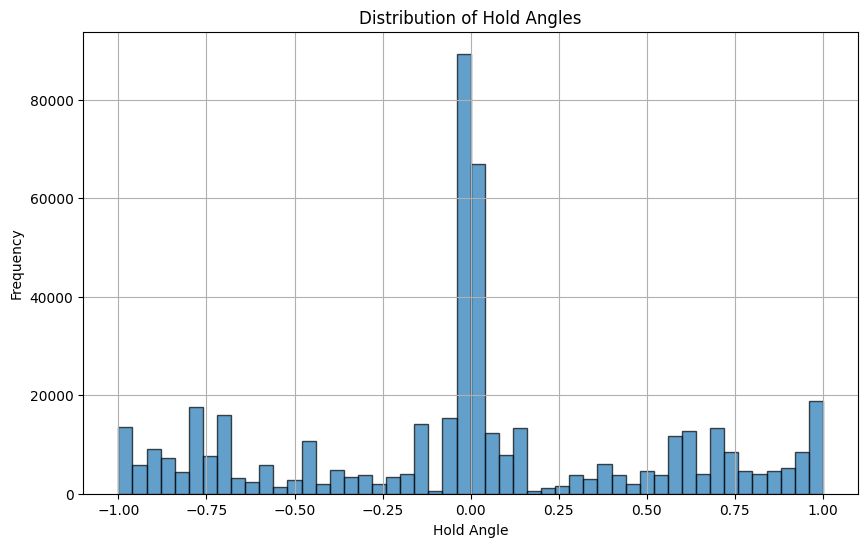

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract hold angle values (6th value in each tuple)
hold_angles = []

for i in range(len(dataset)):
    climb_matrix, row_ids, col_ids, hold_class_ids, val_labels = dataset[i]
    angles = climb_matrix[:, 5]  # 6th value (index 5) in each tuple
    hold_angles.extend(angles)

# Convert hold_angles to a numpy array
hold_angles = np.array(hold_angles)

# Plot the distribution of hold angles
plt.figure(figsize=(10, 6))
plt.hist(hold_angles, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Hold Angle')
plt.ylabel('Frequency')
plt.title('Distribution of Hold Angles')
plt.grid(True)
plt.show()


In [ ]:
id_index_dict = {}
for id in range(1073, 1396):
    id_index_dict[id] = id_to_index(id)
for id in range(1447, 1600):
    id_index_dict[id] = id_to_index(id)
index_to_id_dict = {index: id for id, index in id_index_dict.items()}

sorted_id_index_tuples = sorted(id_index_dict.items(), key=lambda item: item[1])

index2_to_id_dict = {index: id for index, (id, _) in enumerate(sorted_id_index_tuples)}
id_to_index2_dict = {id: index for index, id in index2_to_id_dict.items()}

def id_to_index2(id):
    return id_to_index2_dict.get(id, None)

def index2_to_id(index2):
    return index2_to_id_dict.get(index2, None)

def coordinates_distribution_to_index2(row_id, col_pred):
    for col_id in col_pred:
        index = row_id * 35 + col_id
        # print(index)
        if index in index_to_id_dict:
            # print(index)
            return id_to_index2(index_to_id_dict[index])

    print("Invalid")
    for col_id in col_pred:
        if col_id + 1 < 35:
            index_right = row_id * 35 + (col_id + 1)
            if index_right in index_to_id_dict:
                # print(index_right)
                return id_to_index2(index_to_id_dict[index_right])
        
        if col_id - 1 >= 0:
            index_left = row_id * 35 + (col_id - 1)
            if index_left in index_to_id_dict:
                # print(index_left)
                return id_to_index2(index_to_id_dict[index_left])
        if col_id + 2 < 35:
            index_right = row_id * 35 + (col_id + 2)
            if index_right in index_to_id_dict:
                # print(index_right)
                return id_to_index2(index_to_id_dict[index_right])
        
        if col_id - 2 >= 0:
            index_left = row_id * 35 + (col_id - 2)
            if index_left in index_to_id_dict:
                # print(index_left)
                return id_to_index2(index_to_id_dict[index_left])
    
    return None
# # Sort id_index_dict by index values
# sorted_id_index_dict = dict(sorted(id_index_dict.items(), key=lambda item: item[1]))

# # Print the sorted dictionary
# for id, index in sorted_id_index_dict.items():
#     print(f"ID: {id}, Index: {index}")
# print(17 in id_index_dict)

### Generate RNN Climb ###

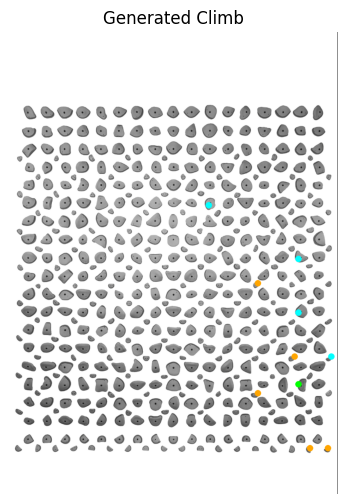

In [ ]:
import torch.nn.functional as F
import random

def generate_climb_from_sequence(initial_holds, initial_vals, num_holds):
    model.eval()
    
    generated_hold_ids = initial_holds.copy()
    generated_vals = initial_vals.copy()
    # Convert initial holds and values to the corresponding tuples and tensors
    initial_tuples = [hold_to_tuple(id_to_index2(hold_id), val) for hold_id, val in zip(initial_holds, initial_vals)]
    current_sequence = torch.tensor(initial_tuples, dtype=torch.float).unsqueeze(0).to(device)

    # Initialize hidden states
    h0, c0 = None, None
    
    max_attempts = 10  # Maximum number of attempts to find a unique hold

    with torch.no_grad():
        for _ in range(num_holds - len(initial_holds)):
            lengths = torch.tensor([current_sequence.size(1)], dtype=torch.int64).to(device)

            row_logits, col_logits, hold_class_logits, val_class_logits, angle_pred, h0, c0 = model(current_sequence, lengths, h0, c0)
            
            # Apply softmax to convert logits to probabilities
            row_class_prob = F.softmax(row_logits, dim=1)
            col_class_prob = F.softmax(col_logits, dim=1)
            hold_class_prob = F.softmax(hold_class_logits, dim=1)
            val_class_prob = F.softmax(val_class_logits, dim=1)

            # Sample the next hold_val_class_id from the probability distribution

            row_id = torch.argmax(row_class_prob, dim=1).item()
            col_pred = [torch.argmax(col_class_prob, dim=1).item()]
            val_class = torch.argmax(val_class_prob, dim=1).item()

            topk_hold_values, topk_hold_indices = torch.topk(hold_class_prob, 10)
            topk_hold_indices = topk_hold_indices.squeeze().tolist()

            hold_class_id = random.choice(topk_hold_indices[:3])

            # Ensure the hold is unique
            attempts = 0
            while index2_to_id(hold_class_id) in generated_hold_ids and attempts < max_attempts:
                hold_class_id = random.choice(topk_hold_indices)
                attempts += 1

            # If we exceed max attempts, break to avoid infinite loop
            if attempts >= max_attempts:
                print("Exceeded max attempts to find unique hold.")
                break
            
            generated_hold_ids.append(index2_to_id(hold_class_id))
            generated_vals.append(val_class)

            # Prepare the next input
            next_tuple = hold_to_tuple(hold_class_id, val_class)
            next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
            
            # Concatenate next_tensor along the sequence dimension (dim=1)
            current_sequence = torch.cat((current_sequence, next_tensor), dim=1)

    generated_hold_class_ids = [id_to_class_id(hold_id) for hold_id in initial_holds]
    return generated_hold_ids, generated_vals, generated_hold_class_ids

def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        # id_2-=2
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

def plot_distributions(row_class_prob, col_class_prob):
    # Convert tensors to numpy arrays for plotting
    row_class_prob_np = row_class_prob.squeeze().cpu().numpy()
    col_class_prob_np = col_class_prob.squeeze().cpu().numpy()

    # Plot the row class probabilities
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(row_class_prob_np)), row_class_prob_np)
    plt.xlabel('Row Class Index')
    plt.ylabel('Probability')
    plt.title('Row Class Probabilities')

    # Plot the col class probabilities
    plt.subplot(1, 2, 2)
    plt.bar(range(len(col_class_prob_np)), col_class_prob_np)
    plt.xlabel('Column Class Index')
    plt.ylabel('Probability')
    plt.title('Column Class Probabilities')

    plt.tight_layout()
    plt.show()

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
    # green, cyan, magenta, orange
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

# hold_ids, vals = generate_climb(model, 1081, 3, 12)

# initial_holds = [1081,1077]
# initial_vals = [3,3]  
# hold_ids, vals = generate_climb_from_sequence(model, initial_holds, initial_vals, 12)
# climb_to_image(hold_ids, vals) 

def create_random_climb_image(filtered_df):
    if not filtered_df.empty:
        # Select a random row
        random_row = filtered_df.sample(n=1).iloc[0]

        # Extract the frame and climb name from the random row
        random_frame = random_row['frames']
        climb_name = random_row['name']  # Adjust this according to the actual column name in your DataFrame

        # Create the image for the random frame
        frame_to_image(random_frame)

        # Print the climb name
        print("Climb Name:", climb_name)
        
        # Convert the frame to IDs
        ids_list_1, ids_list_2 = frame_to_ids(random_frame)

        # Initialize lists to store predictions
        predicted_hold_ids = []
        predicted_vals = []
        
        # Iterate through each ID and predict the next hold
        initial_holds = ids_list_1[:1] 
        initial_vals = ids_list_2[:1]  

        for i in range(1, len(ids_list_1)):
            hold_ids, vals, hold_class_ids = generate_climb_from_sequence(initial_holds, initial_vals, len(initial_holds) + 1)
            predicted_hold_ids.append(hold_ids[-1])
            predicted_vals.append(vals[-1])
            print(f"Actual Hold: {ids_list_1[i]} Predicted Hold: {hold_ids[-1]}, Actual Hold Class: {id_to_index2(ids_list_1[i])}, Predicted Hold Class: {id_to_index2(hold_ids[-1])}")
            initial_holds.append(ids_list_1[i])
            initial_vals.append(ids_list_2[i])

        # Calculate accuracy
        correct_predictions = sum(1 for i in range(2, len(ids_list_1)) if ids_list_1[i] == predicted_hold_ids[i-2])
        accuracy = correct_predictions / (len(ids_list_1) - 2)
        print(f"Prediction Accuracy: {accuracy:.2f}")

        # Create the image for the predicted holds
        climb_to_image(predicted_hold_ids, predicted_vals)
    else:
        print("The DataFrame is empty.")

# Example usage:
# Assuming you have a DataFrame `filtered_df` and a trained model `model`
# create_random_climb_image(filtered_df)

predicted_hold_ids, predicted_vals, generated_hold_class_ids = generate_climb_from_sequence([1447], [3], 10)
climb_to_image(predicted_hold_ids, predicted_vals)


In [ ]:
# show(filtered_df)
print(torch.cuda.is_available())

True
